In [1]:
import pandas as pd
import numpy as np
import zipfile 
import pandas as pd
import geopandas as gp
import glob
import json
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from descartes import PolygonPatch
import os
import scipy 

%matplotlib inline

In [2]:
fname = 'nyc-zip-code-tabulation-areas-polygons.geojson'
nyc_shape = gp.read_file(fname).drop_duplicates(subset='postalCode')
# nyc_shape.plot(figsize=(5,5))  
nyczips = nyc_shape.postalCode.values.astype(int)
print ("number of NYC zip codes:", len(nyczips))   # Validating the number of zipcodes in NYC.

number of NYC zip codes: 247


In [3]:
#dropping coloumns not in need
nyc_shape.drop([  u'@id', u'BLDGpostalCode', u'ST_FIPS', u'STATE',   u'PO_NAME', u'CTY_FIPS',
             u'OBJECTID', u'Shape_Area', u'Shape_Leng'], axis = 1, inplace = True) 

#renaming the name postalcode with zip 
nyc_shape = nyc_shape.rename(columns={'postalCode' : 'ZipCode'}) 

# convert the zip to numeric format.
nyc_shape['ZipCode'] = pd.to_numeric(nyc_shape['ZipCode'])

In [4]:
violations = pd.read_csv('violation_by_zip.csv')

In [5]:
complaints = pd.read_csv('complaints_by_zip.csv')

In [17]:
litigation = pd.read_csv('litigation_by_zip.csv')

In [7]:
violation_df = violations.groupby(by=violations.zip).agg({'violation_counts':sum, 'buildingid':lambda x: x.nunique()})

In [8]:
violation_df.head()

,violation_counts,buildingid
zip,,
1466.0,6,1
2015.0,1,1
2016.0,44,2
10001.0,11935,295
10002.0,58775,1018


In [9]:
violation_df.shape

(196, 2)

In [10]:
violation_df.reset_index(inplace=True)

In [11]:
violation_df.head()

,zip,violation_counts,buildingid
0,1466.0,6,1
1,2015.0,1,1
2,2016.0,44,2
3,10001.0,11935,295
4,10002.0,58775,1018


In [12]:
complaints.columns

Index(['buildingid', 'zip', 'complaints_counts'], dtype='object')

In [13]:
complaints_df = complaints.groupby(by=complaints.zip).agg({'complaints_counts':sum, 'buildingid':lambda x: x.nunique()})

In [14]:
complaints_df.reset_index(inplace=True)
complaints_df.head()

,zip,buildingid,complaints_counts
0,0.0,1,1
1,2014.0,1,13
2,2016.0,2,5
3,10001.0,261,3945
4,10002.0,839,13303


In [17]:
complaints_df.shape

(194, 3)

In [20]:
litigation_df = litigation.groupby(by=litigation.zip).agg({'litigation_counts':sum, 'buildingid':lambda x: x.nunique()})

In [21]:
litigation_df.reset_index(inplace=True)
litigation_df.head()

,zip,litigation_counts,buildingid
0,10001.0,4765,91
1,10002.0,16968,306
2,10003.0,10655,269
3,10004.0,60,2
4,10005.0,122,4


In [22]:
litigation_df.shape

(183, 3)

### Merge the HPD complaints, violations and litigations

In [23]:
Hpd_df = violation_df.merge(complaints_df,on='zip', how='outer').merge(litigation_df, on='zip', how='outer')

In [24]:
Hpd_df.head()

,zip,violation_counts,buildingid_x,buildingid_y,complaints_counts,litigation_counts,buildingid
0,1466.0,6.0,1.0,NaN,NaN,NaN,NaN
1,2015.0,1.0,1.0,NaN,NaN,NaN,NaN
2,2016.0,44.0,2.0,2.0,5.0,NaN,NaN
3,10001.0,11935.0,295.0,261.0,3945.0,4765.0,91.0
4,10002.0,58775.0,1018.0,839.0,13303.0,16968.0,306.0


In [25]:
Hpd_df.rename(columns={'buildingid_x':'Count_bldg_violat', 'buildingid_y':\
                       'Count_bldg_comp','buildingid':'Count_bldg_liti'},inplace=True)

### Merge with Zipcode geojson

In [26]:
nyc_shape.head()

,borough,geometry,ZipCode
0,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [27]:
Hpd_df['ZipCode'] = pd.to_numeric(Hpd_df.zip)

In [28]:
Hpd_shape = nyc_shape.merge(Hpd_df,on='ZipCode',how='inner')

In [29]:
Hpd_shape.head(2)

,borough,geometry,ZipCode,zip,violation_counts,Count_bldg_violat,Count_bldg_comp,complaints_counts,litigation_counts,Count_bldg_liti
0,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,11372.0,40222.0,906.0,640.0,10566.0,14710.0,270.0
1,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,11004.0,429.0,48.0,91.0,305.0,296.0,12.0


In [30]:
Hpd_shape.shape

(184, 10)

In [31]:
Hpd_shape.dropna(inplace=True)

/Users/shalmali/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


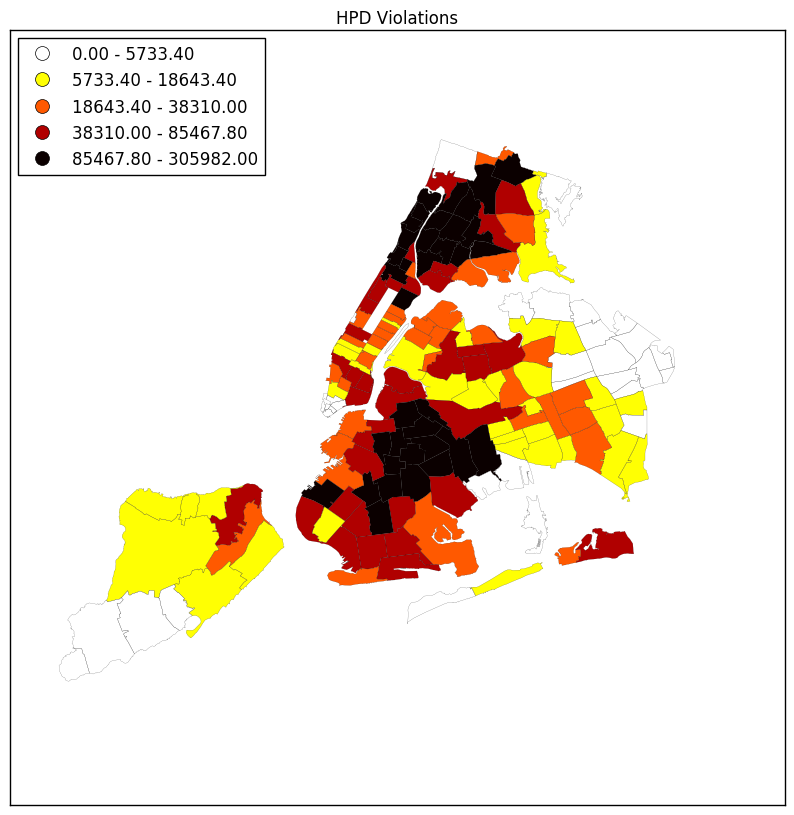

In [33]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
Hpd_shape.plot(column='violation_counts',scheme='QUANTILES',cmap='hot_r',alpha=1,linewidth=0.1,ax=ax, legend=True)
plt.title("HPD Violations")
plt.legend()
plt.show()

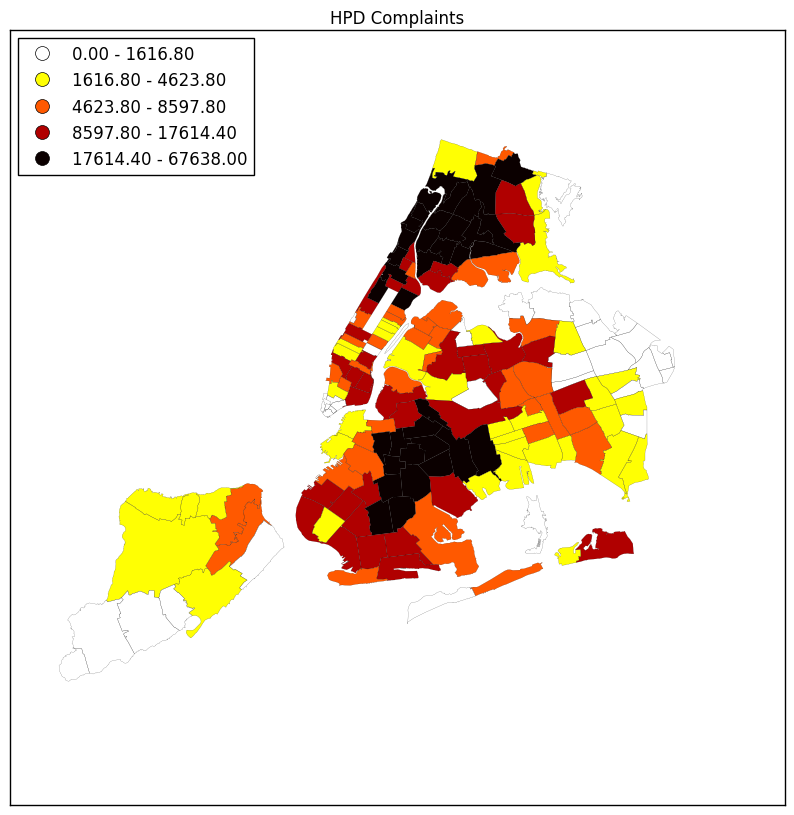

In [35]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
Hpd_shape.plot(column='complaints_counts',scheme='QUANTILES',cmap='hot_r',alpha=1,linewidth=0.1,ax=ax, legend=True)
plt.title("HPD Complaints")

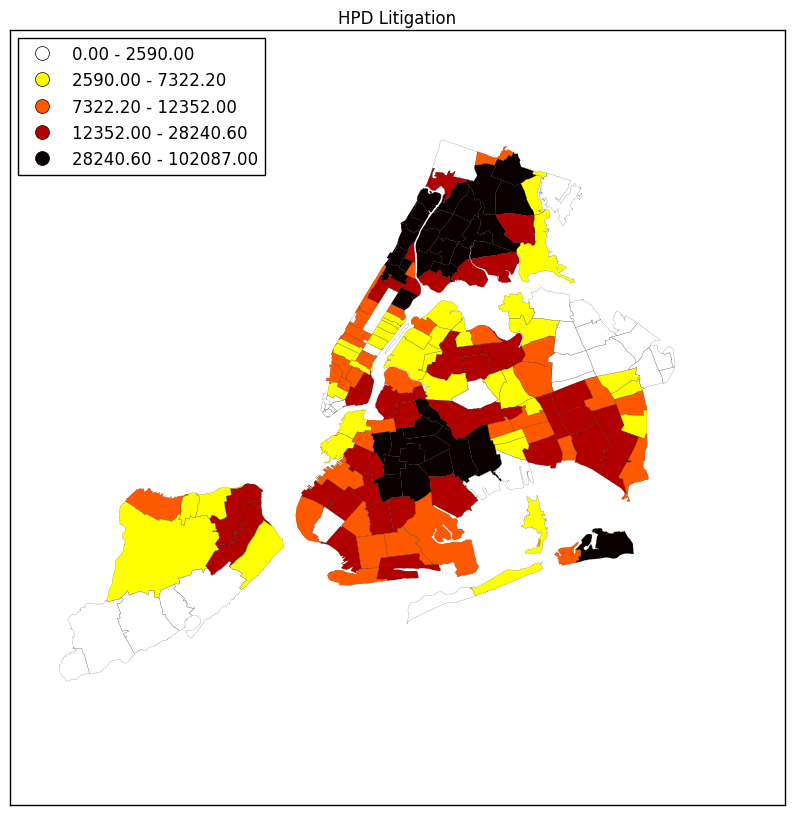

In [36]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
Hpd_shape.plot(column='litigation_counts',scheme='QUANTILES',cmap='hot_r',alpha=1,linewidth=0.1,ax=ax, legend=True)
plt.title("HPD Litigation")

/Users/shalmali/anaconda/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


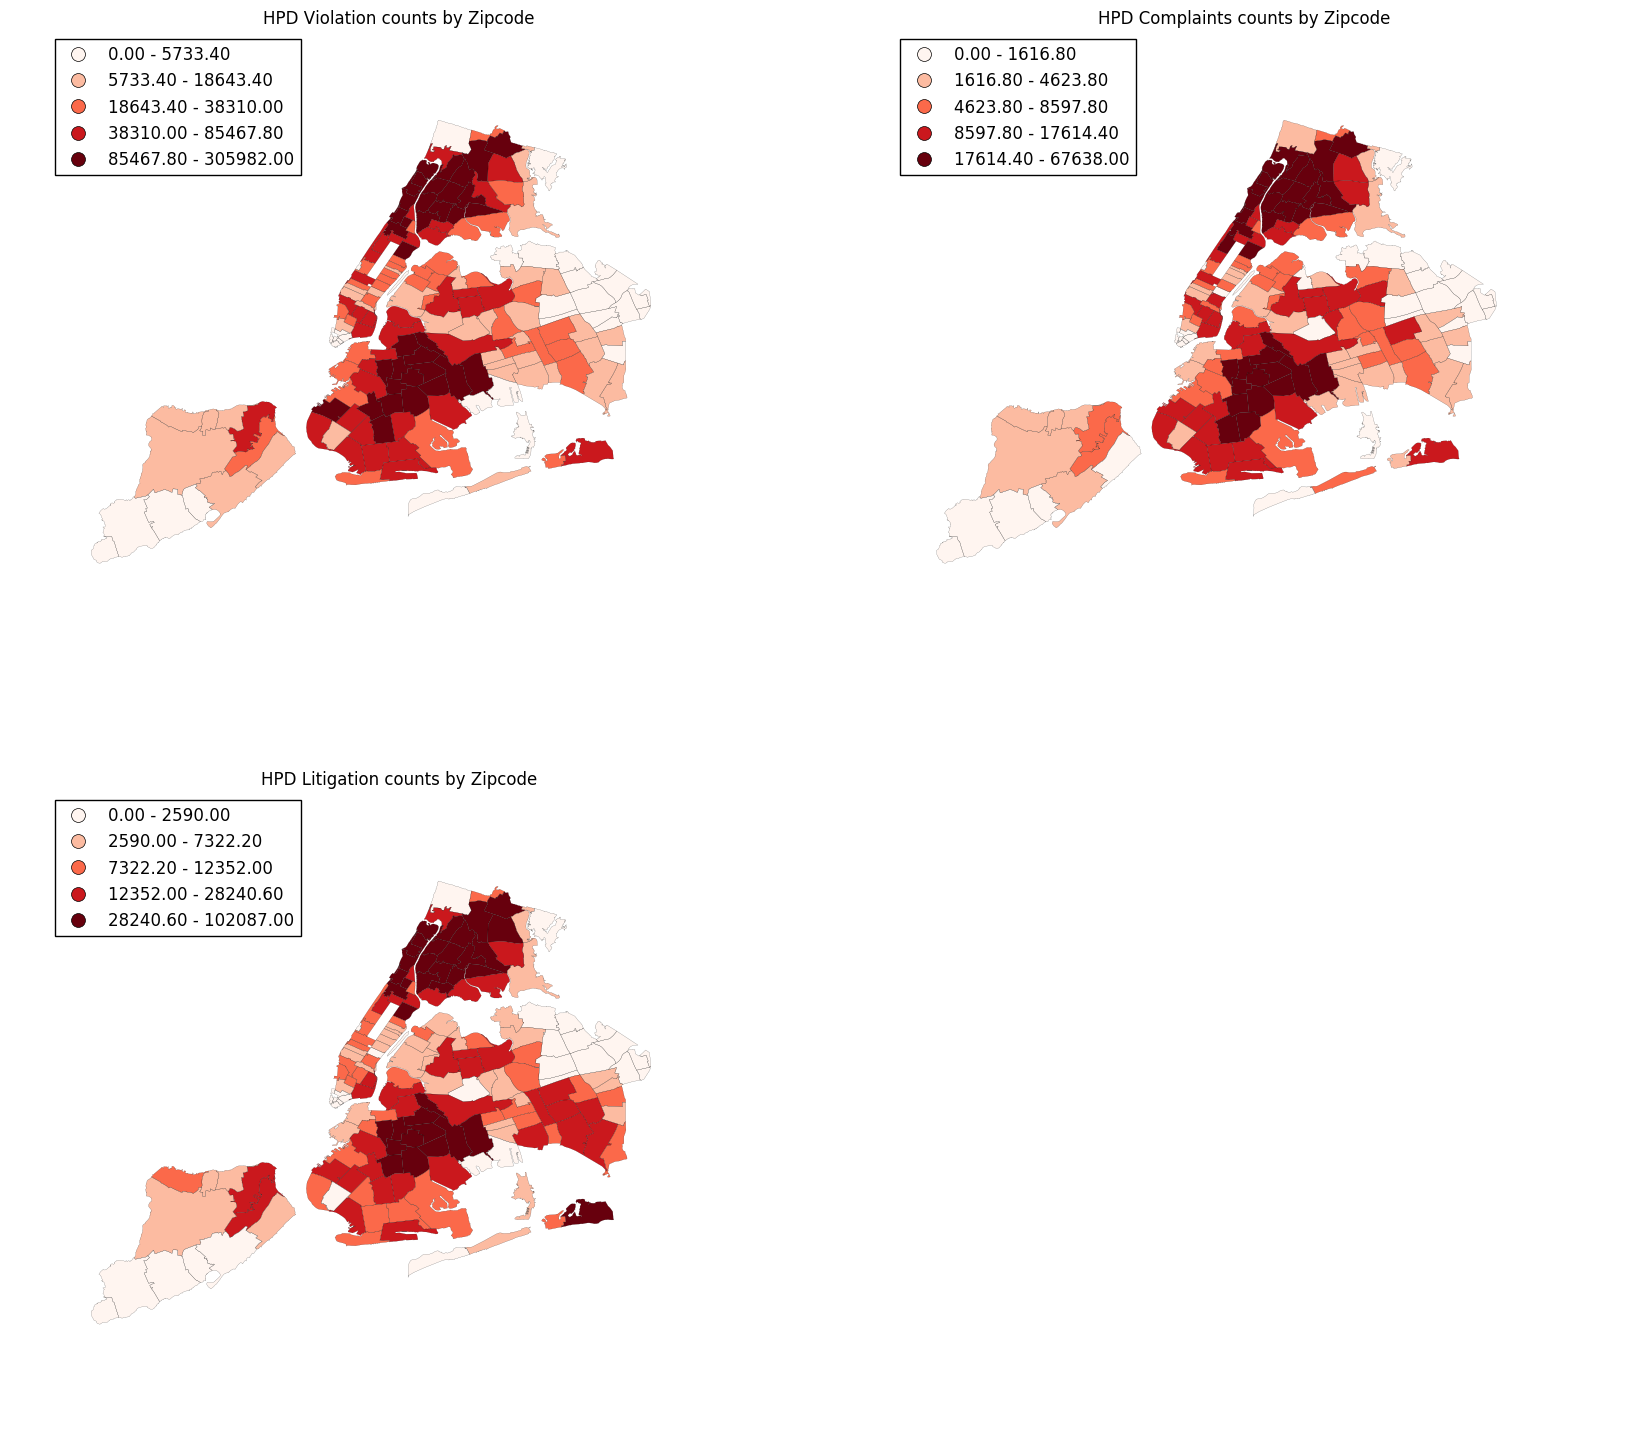

In [54]:
fig = plt.figure(figsize=(20,18))
ax1, ax2, ax3 = fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(223)

Hpd_shape.plot(column='violation_counts',scheme='QUANTILES',colormap='Reds',alpha=1,linewidth=0.1,ax=ax1, legend=True)
ax1.axis('off')
ax1.set_title('HPD Violation counts by Zipcode')

Hpd_shape.plot(column='complaints_counts',scheme='QUANTILES', colormap='Reds',alpha=1,linewidth=0.1,ax=ax2, legend=True)
ax2.axis('off')
ax2.set_title('HPD Complaints counts by Zipcode')

Hpd_shape.plot(column='litigation_counts',scheme='QUANTILES', colormap='Reds',alpha=1,linewidth=0.1,ax=ax3, legend=True)
ax3.axis('off')
ax3.set_title('HPD Litigation counts by Zipcode')